In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from joblib import parallel_backend
import matplotlib.pyplot as plt



In [2]:
# Load the dataset
data = pd.read_csv("cleaned_weather_data.csv")
# Define features and target
features = ['TEMP', 'DEWP', 'MAX', 'MIN', 'PRCP', 'MXSPD', 'GUST']
target = 'WDSP'

# Drop rows with missing target values
data = data.dropna(subset=[target])

# Handle missing values in features by filling only numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())


In [3]:
# Prepare feature matrix and target vector
X = data[features]
y = data[target]

# Add polynomial features (degree 2 for quadratic interaction)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Get the polynomial feature names
poly_features = poly.get_feature_names_out(features)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)


In [4]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [5]:
# Define the Gradient Boosting Regressor with early stopping
gbm = GradientBoostingRegressor(random_state=42, n_iter_no_change=10, warm_start=True)


In [6]:
# Define the hyperparameters grid for RandomizedSearchCV with a wider range
param_dist = {
    'n_estimators': [200, 300, 500, 800, 1000],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'loss': ['squared_error', 'absolute_error', 'huber']
}


In [8]:
# Perform RandomizedSearchCV with 5-fold cross-validation and more iterations
random_search = RandomizedSearchCV(gbm, param_distributions=param_dist, n_iter=50, cv=5, random_state=42, n_jobs=2, verbose=2)
# Fit the model with parallel backend to avoid worker timeouts
with parallel_backend('loky', inner_max_num_threads=4):
    random_search.fit(X_train, y_train)



Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [9]:
# Best parameters found by RandomizedSearchCV
print("Best Parameters:", random_search.best_params_)

# Train the best model found by RandomizedSearchCV
best_gbm = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_gbm.predict(X_test)


Best Parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_samples_split': 5, 'max_depth': 3, 'loss': 'squared_error', 'learning_rate': 0.2}


In [10]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print("Selected Features:", poly_features)
print("Mean Squared Error:", mse)
print("R² Score:", r2)


Selected Features: ['TEMP' 'DEWP' 'MAX' 'MIN' 'PRCP' 'MXSPD' 'GUST' 'TEMP^2' 'TEMP DEWP'
 'TEMP MAX' 'TEMP MIN' 'TEMP PRCP' 'TEMP MXSPD' 'TEMP GUST' 'DEWP^2'
 'DEWP MAX' 'DEWP MIN' 'DEWP PRCP' 'DEWP MXSPD' 'DEWP GUST' 'MAX^2'
 'MAX MIN' 'MAX PRCP' 'MAX MXSPD' 'MAX GUST' 'MIN^2' 'MIN PRCP'
 'MIN MXSPD' 'MIN GUST' 'PRCP^2' 'PRCP MXSPD' 'PRCP GUST' 'MXSPD^2'
 'MXSPD GUST' 'GUST^2']
Mean Squared Error: 1.0753017776571783
R² Score: 0.7442265134877992


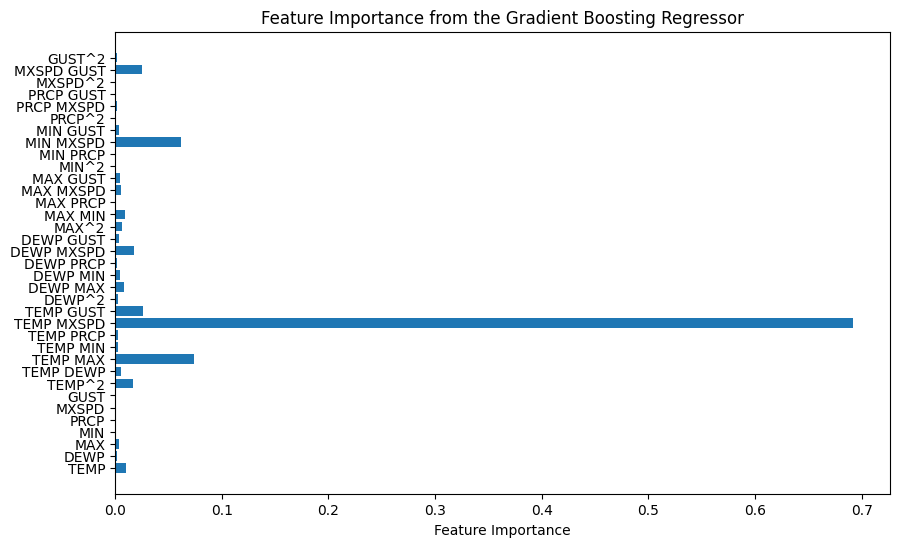

In [11]:
# Visualizing the results
# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(poly_features, best_gbm.feature_importances_)
plt.xlabel("Feature Importance")
plt.title("Feature Importance from the Gradient Boosting Regressor")
plt.show()


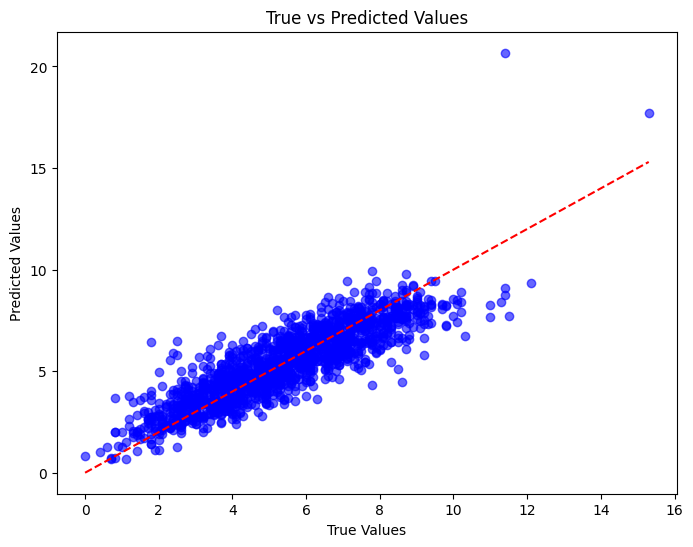

In [12]:
# Plotting the true vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

In [ ]:
import joblib
import os

# Define the save path
save_path = r"C:\Users\Haripriya.R\Desktop\studies\SmartWindDashboard\models\gbm"

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Save the scaler, polynomial transformer, and trained model
scaler_path = os.path.join(save_path, 'scaler.joblib')
poly_path = os.path.join(save_path, 'poly_features.joblib')
model_path = os.path.join(save_path, 'gbm_model.joblib')

joblib.dump(scaler, scaler_path)
joblib.dump(poly, poly_path)
joblib.dump(best_gbm, model_path)

print(f"Model and preprocessing steps saved successfully at {save_path}")
